In [73]:
import os 

import random
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from src.models.cnn import CNN
from src.utility.generate_images import generateImages
import torch.nn as nn
import torch.optim as optim
import shutil
import torch.nn.functional as F
from distutils.dir_util import copy_tree

#### Make Synthetic + Train Dataset

In [79]:
def make_augmented_train(
        train_dir,
        test_dir,
        synthetic_dir,
        augmented_train_dir,
        train_perc,
        synthetic_perc
    ):
    # make directories if they don't already exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(synthetic_dir, exist_ok=True)
    os.makedirs(augmented_train_dir, exist_ok=True)
    
    # loop through each class
    for subfolder in os.listdir(train_dir):
        os.makedirs(f"{augmented_train_dir}/{subfolder}", exist_ok=True)
    
        all_train_imgs = os.listdir(train_dir + '/' + subfolder)
        all_synthetic_imgs = os.listdir(synthetic_dir + '/' + subfolder)

        if subfolder == 'NonDemented':
            from_directory = f"{train_dir}/{subfolder}"
            to_directory = f"{augmented_train_dir}/{subfolder}"
            copy_tree(from_directory, to_directory)    
        else:
            chosen_train_imgs = random.sample(all_train_imgs, round(len(all_train_imgs)*train_perc))
            chosen_synthetic_imgs = random.sample(all_synthetic_imgs, round(len(all_train_imgs)*synthetic_perc))
            for img_name in chosen_train_imgs+chosen_synthetic_imgs:
                
                dst = f"{augmented_train_dir}/{subfolder}/{img_name}"

                if 'generated' in img_name:
                    src = f"{synthetic_dir}/{subfolder}/{img_name}"
                else:
                    src = f"{train_dir}/{subfolder}/{img_name}"
                    
                shutil.copy(src, dst)

#### Data Transformation

In [46]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])

#### Display example images

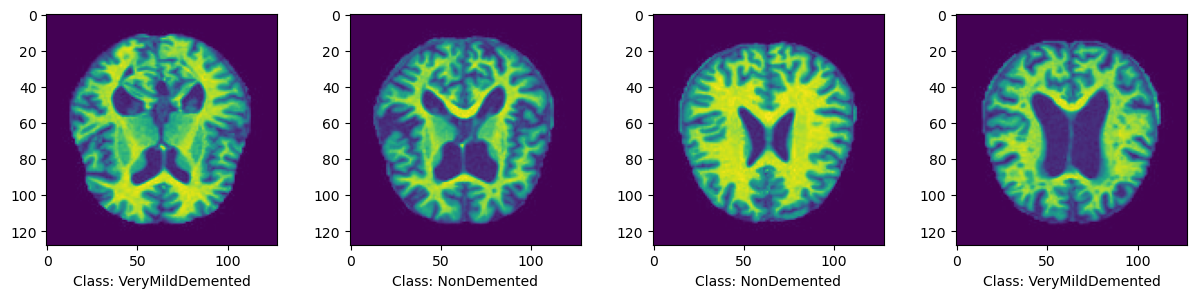

In [50]:
train_dataset = datasets.ImageFolder(augmented_train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Get one batch of images
images, labels = next(iter(train_loader))

# Number of images you want to display
num_images = 4

# Create a grid for the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

class_names = train_dataset.classes

for i in range(num_images):
    # Convert image tensor to numpy array and transpose the axes
    # PyTorch tensors are in (C, H, W) format, and Matplotlib expects (H, W, C)
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('on')  # Turn off axis
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}') # Set the label as x-axis label

plt.show()

#### Train CNN

In [75]:
def train_model(
        train_dir,
        test_dir,
        synthetic_dir,
        augmented_train_dir,
        train_percs,
        synthetic_percs,
        transform,
        num_sim
):
    for train_perc,synthetic_perc in zip(train_percs, synthetic_percs):
        
        for n in range(num_sim):
    
            # make synthetic + real mix
            make_augmented_train(train_dir,test_dir,synthetic_dir,
                                augmented_train_dir,train_perc,synthetic_perc)
            
            # load images
            train_dataset = datasets.ImageFolder(augmented_train_dir, transform=transform)
            test_dataset = datasets.ImageFolder(test_dir, transform=transform)
            
            # create dataloader
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

            # Split the dataset into training and validation sets (80-20 split)
            train_size = int(0.8 * len(train_dataset))
            val_size = len(train_dataset) - train_size
            train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

            # Create data loaders
            batch_size = 64
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size)

            # Initialize the model
            model = CNN(
                in_channels=1,
                num_classes=4
            )

            # Define the loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # train model
            best_val_loss = float('inf')
            patience = 5  # Number of epochs to wait for improvement before stopping
            patience_counter = 0
            train_losses = []
            val_losses = []
            val_accuracies = []
            all_preds = []
            all_labels = []
            num_epochs=10

            for epoch in range(num_epochs):
                
                model.train()
                train_loss = 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * images.size(0)

                model.eval()
                val_loss = 0.0
                val_corrects = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item() * images.size(0)
                        _, preds = torch.max(outputs, 1)
                        val_corrects += torch.sum(preds == labels.data)
                        all_preds.extend(preds.view(-1).cpu().numpy())
                        all_labels.extend(labels.view(-1).cpu().numpy())

                train_loss = train_loss / len(train_loader.dataset)
                val_loss = val_loss / len(val_loader.dataset)
                val_accuracy = val_corrects.double() / len(val_loader.dataset)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
                
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0  # Reset counter
                    torch.save(model.state_dict(), 'best_model.pth') # Save the model
                else:
                    patience_counter += 1

                # Early stopping check
                if patience_counter >= patience:
                    print("Stopping early due to no improvement in validation loss.")
                    break
                
                # store results in dataframe
                dat = {
                    "sim_num":[n]*len(vaL_losses),
                    "train_percentage":[train_perc]*len(vaL_losses),
                    "synthetic_percentage":[synthetic_perc_perc]*len(vaL_losses),
                    "epoch": range(len(val_losses)),
                    "val_losses": val_losses,
                    "train_losses": train_losses,
                    "val_accuracies": [acc.item() for acc in val_accuracies]
                }

                result_df = pd.DataFrame(data=dat)

                return result_df

In [82]:
os.listdir(train_dir)

['.DS_Store',
 'VeryMildDemented',
 'ModerateDemented',
 'MildDemented',
 'NonDemented']

In [83]:
train_dir = "data/alzheimer_mri/train"
test_dir = "data/alzheimer_mri/test"
synthetic_dir = "data/alzheimer_mri/synthetic"
dataset_dir = "data/alzheimer_mri/train_and_synthetic"

train_model(
    train_dir=train_dir,
    test_dir=test_dir, 
    synthetic_dir=synthetic_dir,
    augmented_train_dir=dataset_dir,
    train_percs=[0.9],
    synthetic_percs=[0.1],
    transform=transform,
    num_sim=1
)

NotADirectoryError: [Errno 20] Not a directory: 'data/alzheimer_mri/train/.DS_Store'

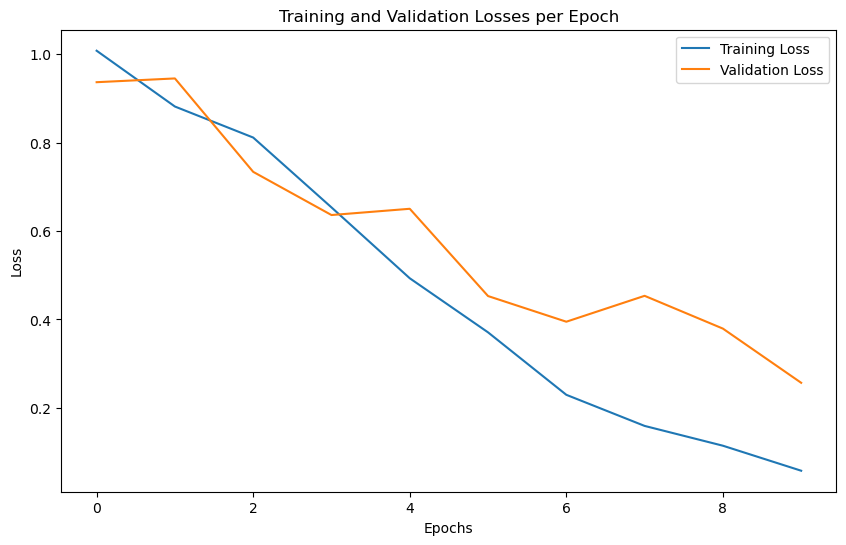

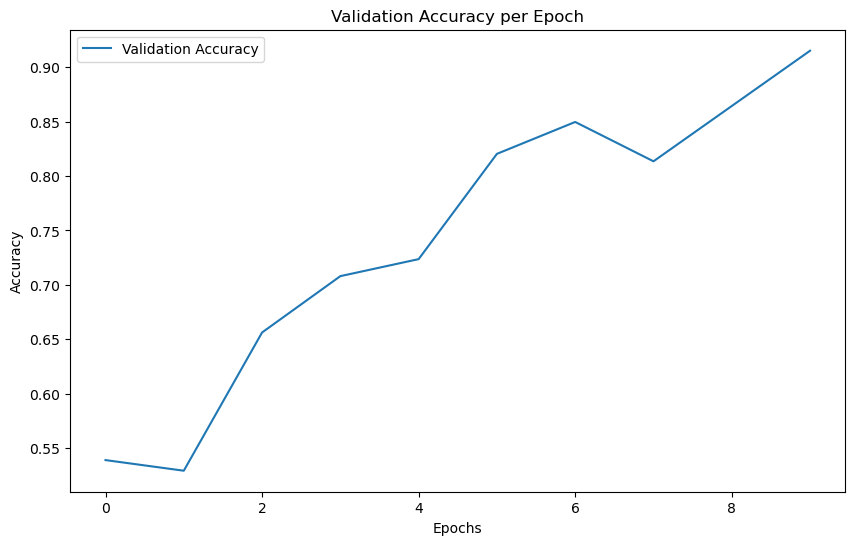

In [56]:
import matplotlib.pyplot as plt
#0.2543
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

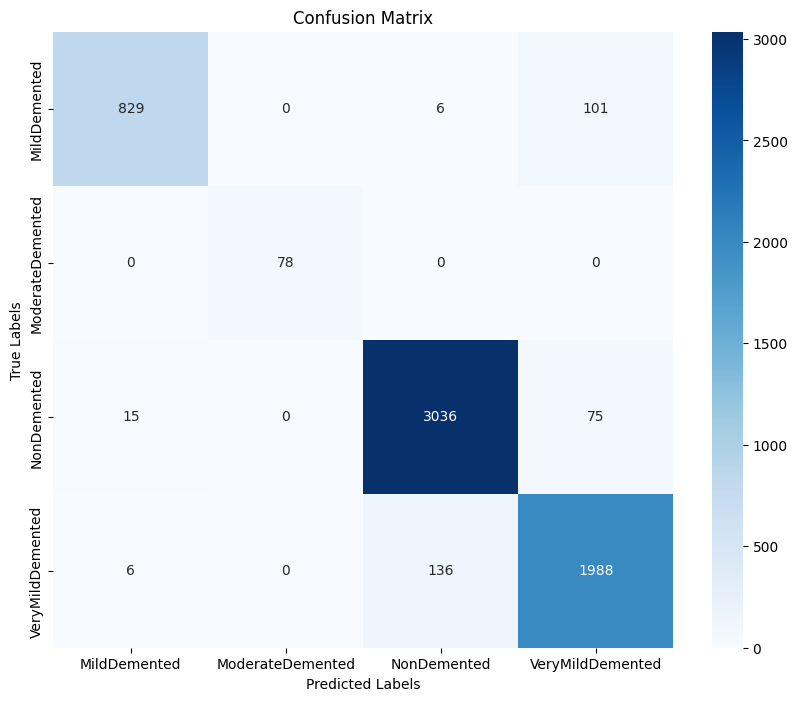

In [73]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model.pth')) # This line uses .load() to read a .pth file and load the network weights on to the architecture.
model.eval() # enabling the eval mode to test with new samples.

In [ ]:
inputs = torch.randn(1,1,128,128)
inputs = inputs.to(device) # You can move your input to gpu, torch defaults to cpu

# Run forward pass
with torch.no_grad():
    output = model(inputs)

_, pred = torch.max(output, 1)

pred


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Storage for predictions and actual labels
all_preds = []
all_labels = []

# Evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics for each class
for class_index in range(4):  # Replace num_classes with the actual number of classes
    class_preds = (all_preds == class_index)
    class_labels = (all_labels == class_index)
    accuracy = accuracy_score(class_labels, class_preds)
    precision = precision_score(class_labels, class_preds, zero_division=0)
    recall = recall_score(class_labels, class_preds, zero_division=0)

    class_name = class_names[class_index]

    print(f"Class name {class_name}({class_index}) - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

cm = confusion_matrix(all_labels, all_preds)
print(cm)

In [ ]:
# Load the image and preprocess it
from PIL import Image

image = Image.open(r"data/alzheimer_mri/train/ModerateDemented/ModerateDemented_0.png")
image_tensor = transform(image).unsqueeze(0).to(device)

#def pred_class(image_tensor):
img_im = image_tensor.unsqueeze(0).to(device)
#uinput = Variable(img_im)
#uinput = uinput.to(device)
out = model(uinput)

index = out.data.cpu().numpy().argmax()
index

In [ ]:
pred_class(image_tensor)